# Tuples Statistics

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

In [2]:
import sys
import os
sys.path.append(os.path.abspath('../modules'))
from hard_rules import candidate_cookies

In [3]:
from tqdm import tqdm

In [4]:
sns.set(rc={'figure.figsize':(12,5)})

In [5]:
data = pd.read_parquet("../data/data.parquet")

## Skip this part
It was used to explore the initial data
We will get back to this later

In [ ]:
tuple_size = 4

all_cookie_tuples = []
# while not found:
random_hh_id = np.random.choice(data['hh_id'])
random_h = data[data['hh_id']==random_hh_id]
if random_h['iiqid'].nunique() > 1:
    for cookie_tuple in itertools.combinations(random_h['iiqid'].unique(), r=tuple_size):
        test_first_pair = candidate_cookies(random_h, cookie_tuple[0], cookie_tuple[1])
        test_second_pair = candidate_cookies(random_h, cookie_tuple[1], cookie_tuple[2])
        if test_first_pair and test_second_pair:
            all_cookie_tuples.append(cookie_tuple)
print(f"found {len(all_cookie_tuples)} {tuple_size}-tuples on HH {random_hh_id}")

### First - pairs

In [ ]:
tuple_size = 2

# i = 0
all_cookie_tuples = dict()
for hh in tqdm(data.hh_id.unique()):
    all_cookie_tuples[hh] = []
    house = data[data['hh_id']==hh]
    if house['iiqid'].nunique() > 1:
        for cookie_tuple in itertools.combinations(house['iiqid'].unique(), r=tuple_size):
            test_pairs = [candidate_cookies(house, c1, c2) 
                          for c1, c2 in zip(cookie_tuple, cookie_tuple[1:])]
            if all(test_pairs):
                all_cookie_tuples[hh].append(cookie_tuple)   

In [ ]:
def cookie_amount(v):
    return len(all_cookie_tuples.get(v))
               
# [len(v) for v in all_cookie_tuples.values()])
max(all_cookie_tuples, key=cookie_amount)

In [ ]:
k = '006OpKMkK2'
len(data.loc[data['hh_id']==k, 'iiqid'])

In [ ]:
pairs_count = pd.Series({k: len(v) for k, v in all_cookie_tuples.items()}, 
             index=all_cookie_tuples.keys(), name='pairs')

In [ ]:
pairs_data = pd.concat([pairs_count,data.groupby('hh_id').count().iiqid], axis=1)
pairs_data.columns = ['pairs', 'cookies']

In [ ]:
sns.scatterplot(data=pairs_data, x='cookies', y='pairs')

### Now 3-tupes

In [ ]:
tuple_size = 3

# i = 0
all_cookie_tuples = dict()
for hh in tqdm(data.hh_id.unique()):
    all_cookie_tuples[hh] = []
    house = data[data['hh_id']==hh]
    if house['iiqid'].nunique() > 1:
        for cookie_tuple in itertools.combinations(house['iiqid'].unique(), r=tuple_size):
            test_pairs = [candidate_cookies(house, c1, c2) 
                          for c1, c2 in zip(cookie_tuple, cookie_tuple[1:])]
            if all(test_pairs):
                all_cookie_tuples[hh].append(cookie_tuple)   

In [ ]:
three_tuples_count = pd.Series({k: len(v) for k, v in all_cookie_tuples.items()}, 
             index=all_cookie_tuples.keys(), name='3-tupes')
three_data = pd.concat([three_tuples_count,data.groupby('hh_id').count().iiqid], axis=1)
three_data.columns = ['3-tupes', 'cookies']

### Wait Lets do 2 to 4 togheter

In [ ]:
houses_cookies_tuples = dict()

for hh in tqdm(data.hh_id.unique(), desc="Houses"):
    houses_cookies_tuples[hh] = dict()
    house = data[data['hh_id']==hh]
    
    # for ts in tqdm(range(2,5), desc="Tuple Size", position=1, leave=False):
    for ts in range(2,5):
        tuple_size = ts   
        houses_cookies_tuples[hh][ts] = []

        if house['iiqid'].nunique() > 1:
            for cookie_tuple in itertools.combinations(house['iiqid'].unique(), r=tuple_size):
                test_pairs = [candidate_cookies(house, c1, c2) 
                              for c1, c2 in zip(cookie_tuple, cookie_tuple[1:])]

                if all(test_pairs):
                    houses_cookies_tuples[hh][ts].append(cookie_tuple)   

## Some EDA

In [6]:
data['constans'] = data[['hh_id',"brand", "model", "os", "browser", "advertisedbrowser"]].apply(lambda x: hash(tuple(x)), axis = 1)

In [7]:
grouped_by_consts = data.groupby('constans')['iiqid'].nunique()

Text(0.5, 0, 'Distinct Cookies')

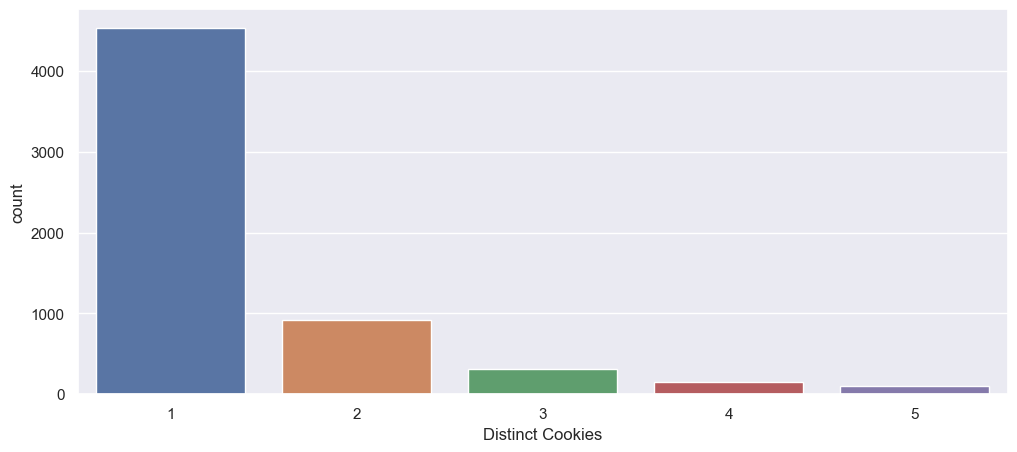

In [8]:
# plt.xticks(range(1,6))
sns.countplot(x=grouped_by_consts[grouped_by_consts < 6])
plt.xlabel("Distinct Cookies")

In [9]:
browsers_data = pd.DataFrame()
for b in data['browser'].unique():
    unique_b = data[data['browser']==b].groupby('constans')['iiqid'].nunique()
    unique_df = pd.DataFrame(unique_b)
    unique_df['browser'] = b
    browsers_data = pd.concat([browsers_data, unique_df])

Text(0.5, 0, 'Distinct Cookies')

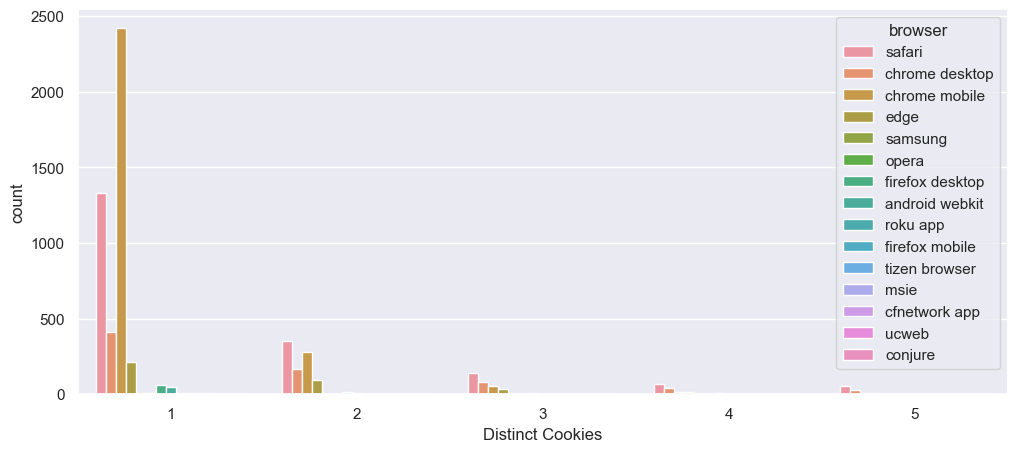

In [10]:
sns.countplot(data=browsers_data[browsers_data['iiqid'] < 6], x='iiqid', hue='browser')
plt.xlabel("Distinct Cookies")

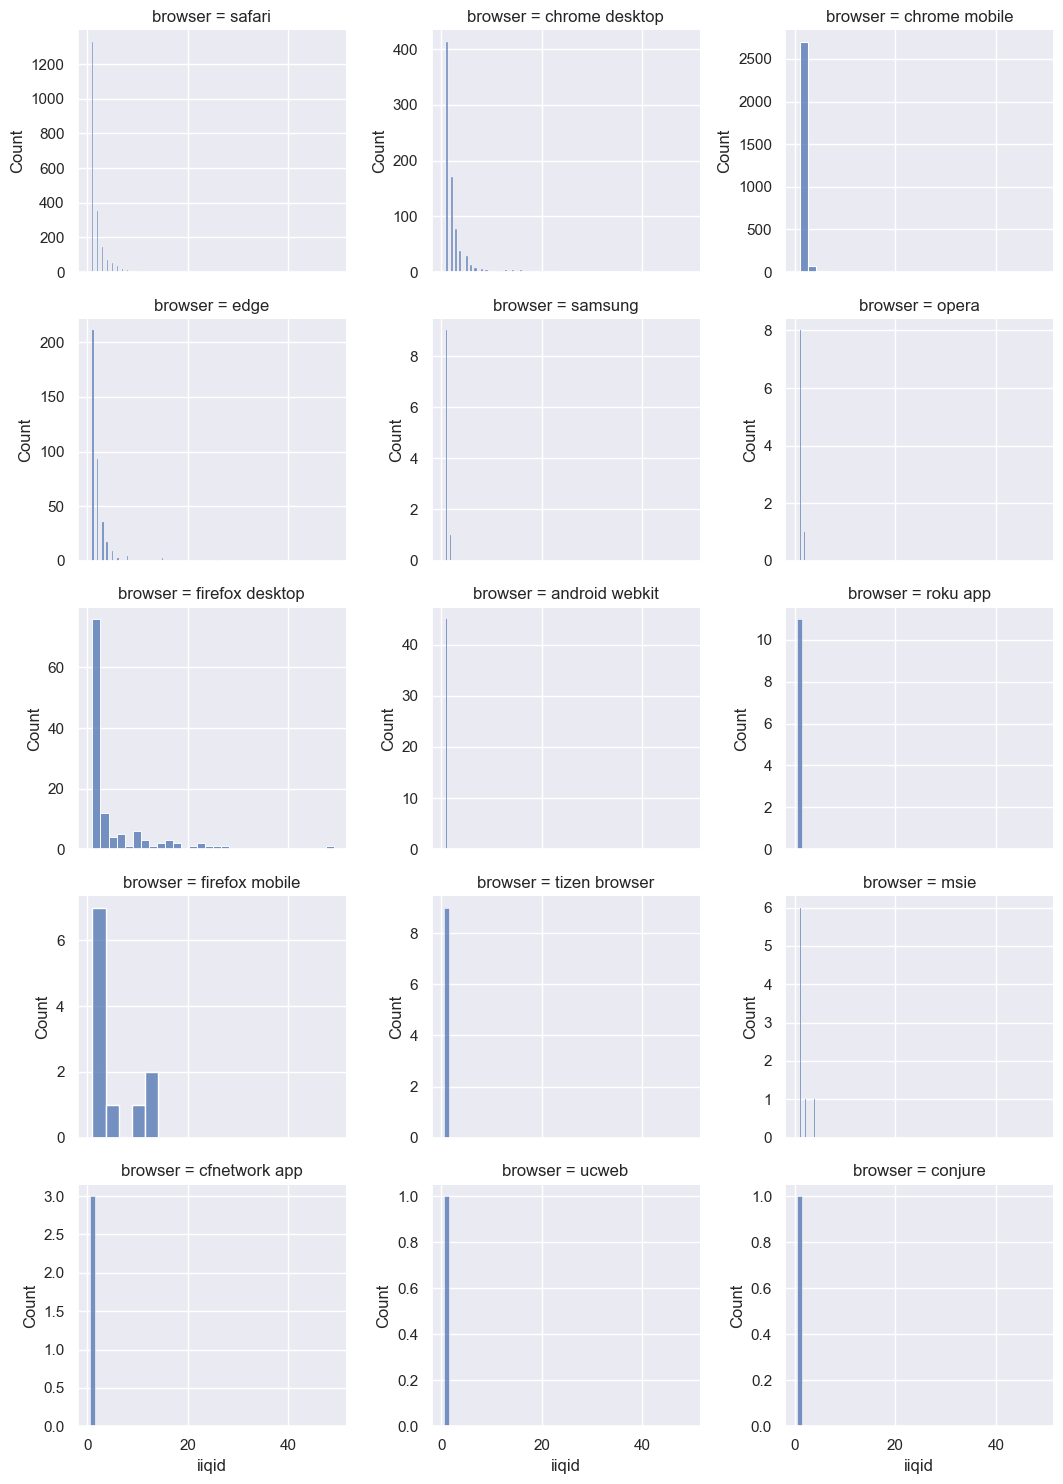

In [11]:
g = sns.FacetGrid(data=browsers_data, col='browser', col_wrap=3, sharey=False, aspect=1.2)
g.map(sns.histplot, 'iiqid')

In [12]:
browsers_data['count'] = browsers_data['iiqid'].apply(lambda x: min(x, 6))

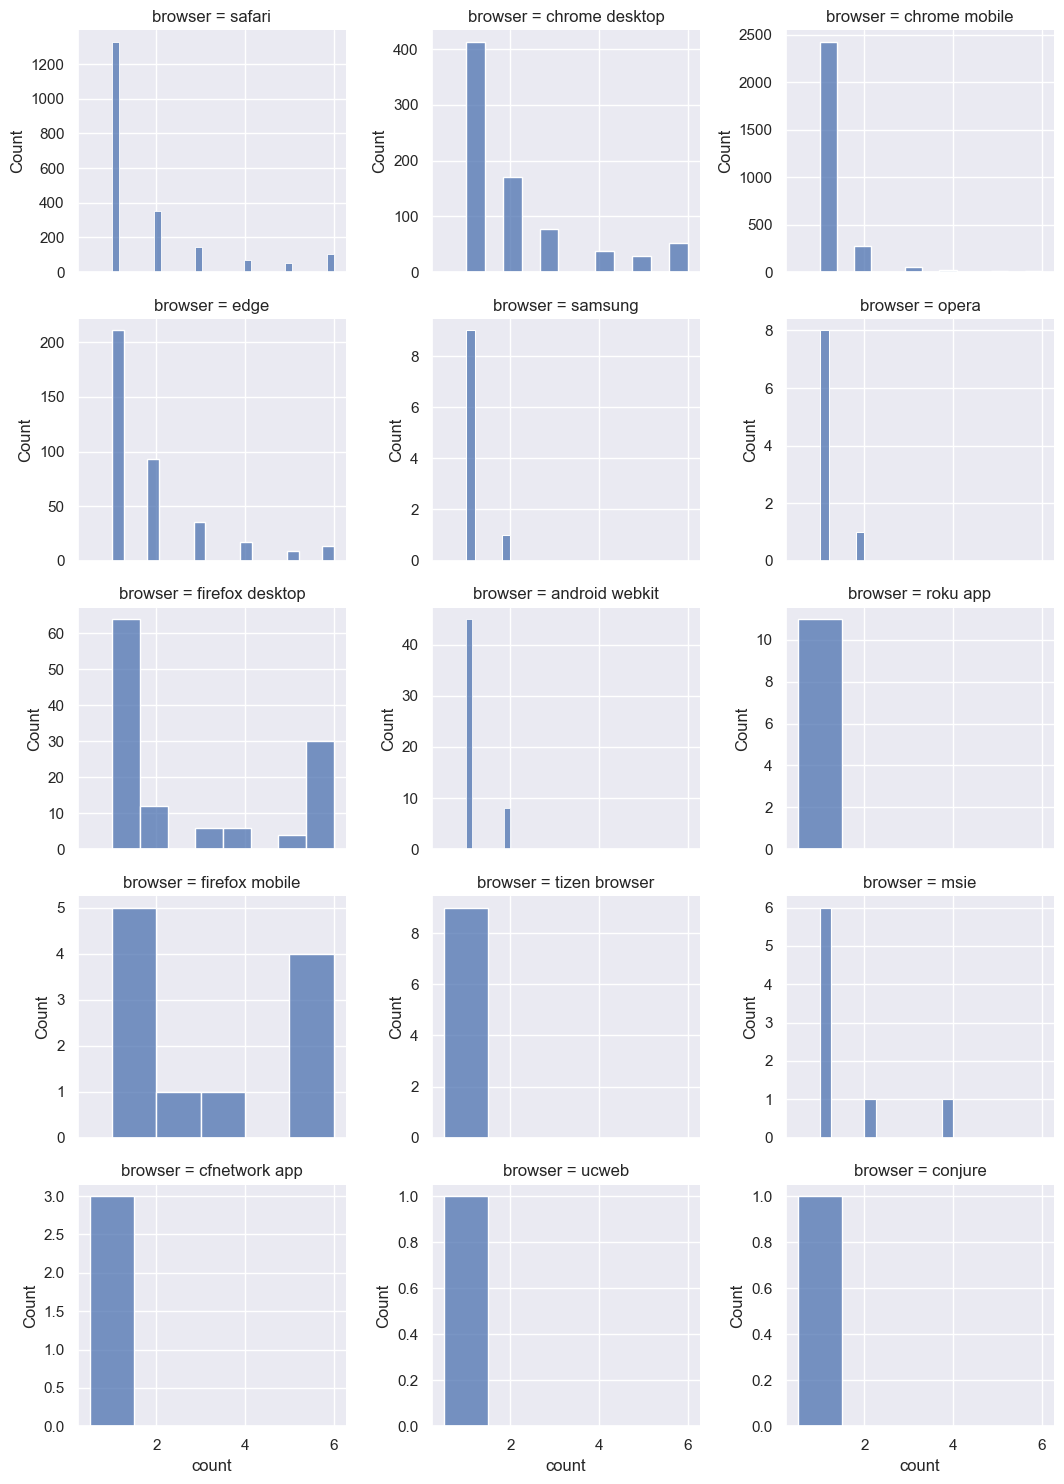

In [13]:
g = sns.FacetGrid(data=browsers_data, col='browser', col_wrap=3, sharey=False, aspect=1.2)
g.map(sns.histplot, 'count')

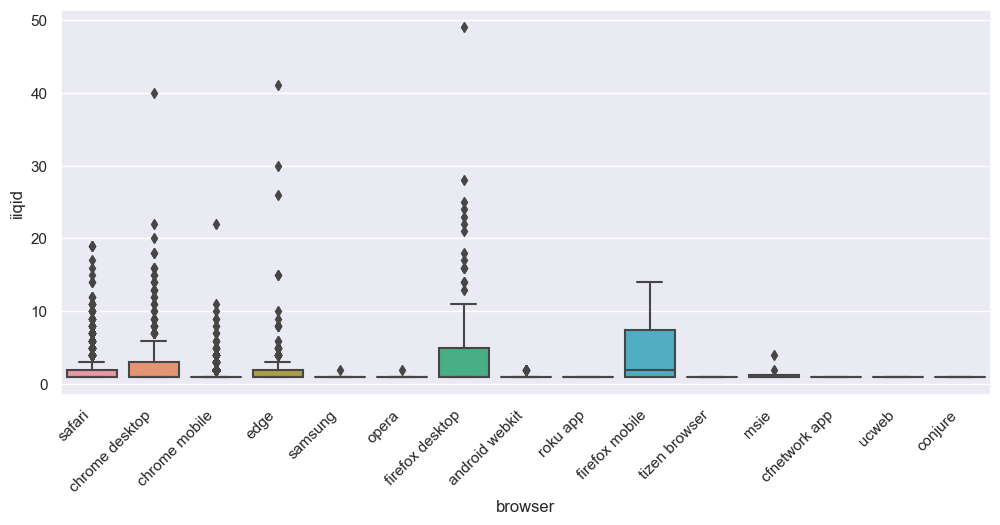

In [14]:
# sorted_index = browsers_data.median().sort_values().index
sns.boxplot(data=browsers_data, y='iiqid', x='browser')
plt.xticks(rotation=45,  ha='right', va='top');

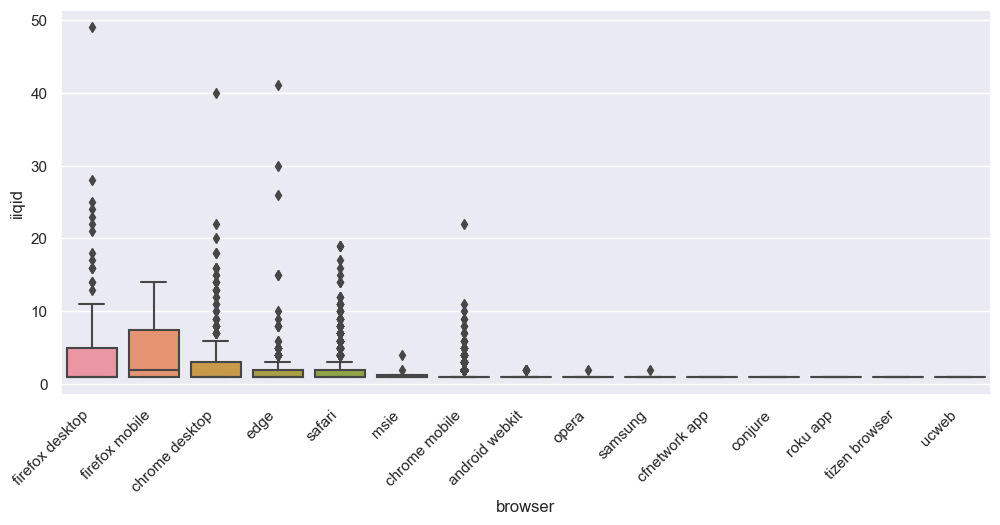

In [15]:
browsers_counts = browsers_data.groupby('browser')['iiqid'].mean().sort_values(ascending=False)
browsers_order = browsers_counts.index.tolist()
sns.boxplot(data=browsers_data, y='iiqid', x='browser', order=browsers_order)
plt.xticks(rotation=45,  ha='right', va='top');

In [16]:
pd.DataFrame({'mean': browsers_counts})

,mean
browser,
firefox desktop,4.860656
firefox mobile,4.727273
chrome desktop,2.366667
edge,2.129630
safari,1.886719
msie,1.500000
chrome mobile,1.204228
android webkit,1.150943
opera,1.111111


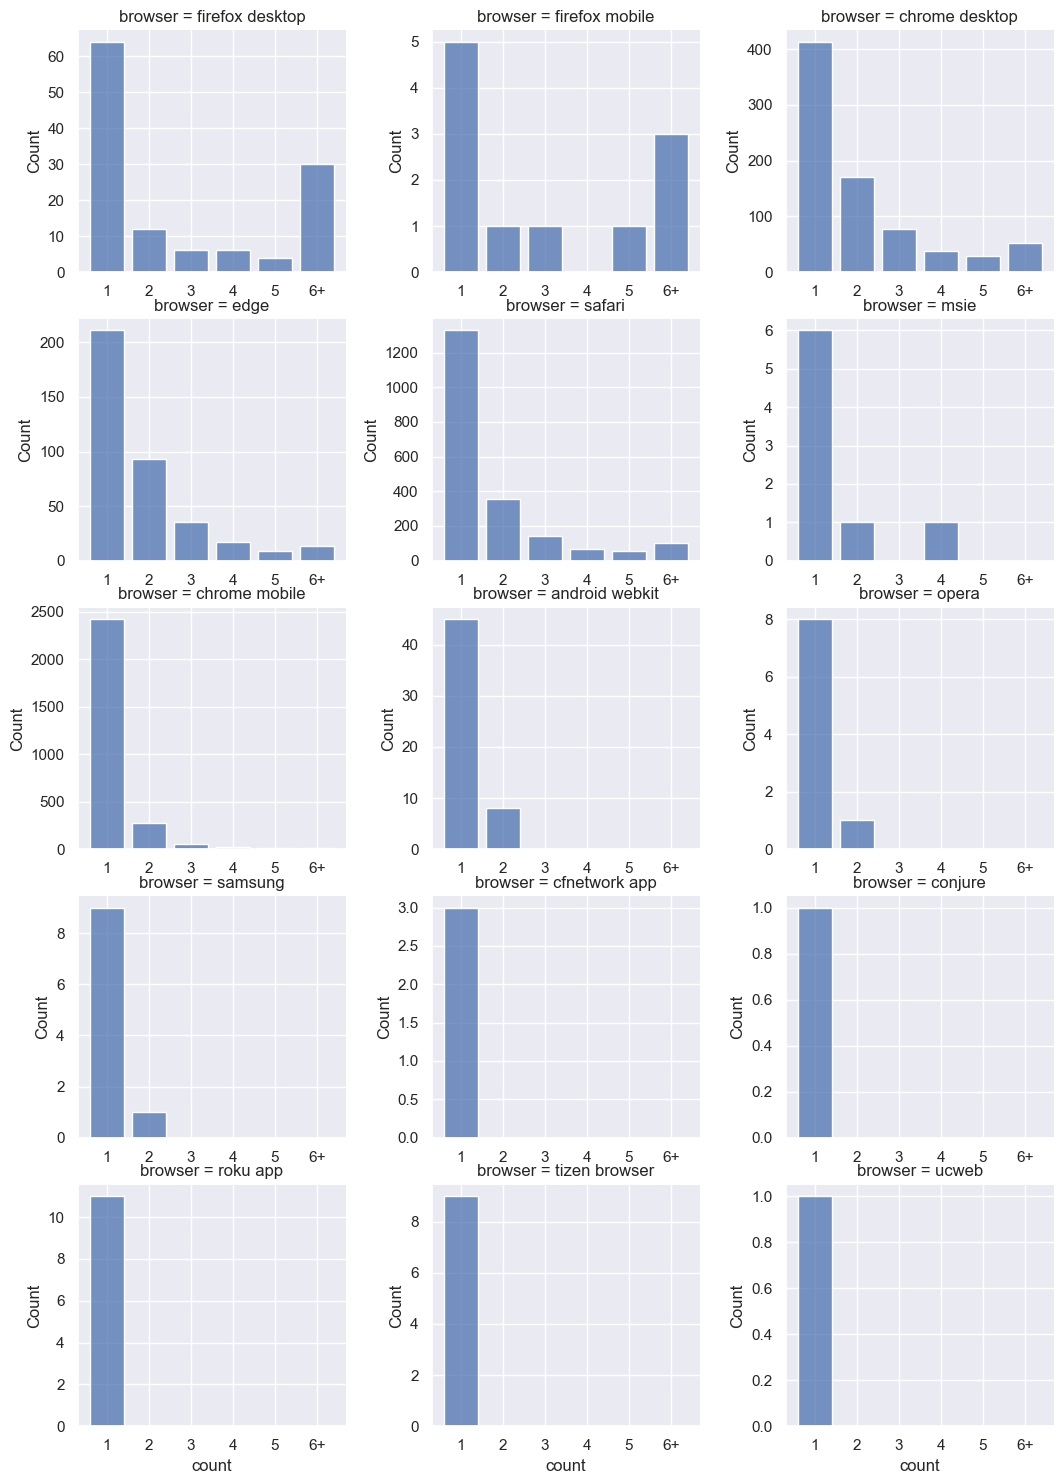

In [17]:
g = sns.FacetGrid(data=browsers_data, col='browser', 
                  col_wrap=3, col_order=browsers_order, sharey=False, aspect=1.2)
g.map(sns.histplot, 'count', bins=6, discrete=True, shrink=0.8)
g.set(xticks=np.arange(1,7))
g.set_xticklabels(['1','2','3','4','5','6+'])
g.fig.tight_layout()
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)

## Data from Atena

In [18]:
atena_data = pd.read_csv("../data/cookies_counts.csv")

In [19]:
atena_data.head()

,num_distinct_iiqid,browser,maid,num_groups
0,33,chrome desktop,7,2542
1,1,webos tv browser,4,31437
2,29,samsung,7,5
3,13,roku app,4,19
4,1190,chrome mobile,7,1


In [20]:
atena_data.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
num_distinct_iiqid,4683.0,3744.16,45215.22,1.0,31.0,283.0,1443.0,2014005.0
maid,4683.0,5.87,1.45,4.0,4.0,7.0,7.0,7.0
num_groups,4683.0,62970.02,1549581.84,1.0,1.0,1.0,7.0,81765555.0


In [21]:
browsers_sum = atena_data.groupby('browser')['num_groups'].sum()
threshold = 5000
len(browsers_sum[browsers_sum >= threshold])
browsers_to_keep = browsers_sum[browsers_sum >= threshold].index.tolist()
atena_popular_browsers = atena_data[atena_data['browser'].isin(browsers_to_keep)]

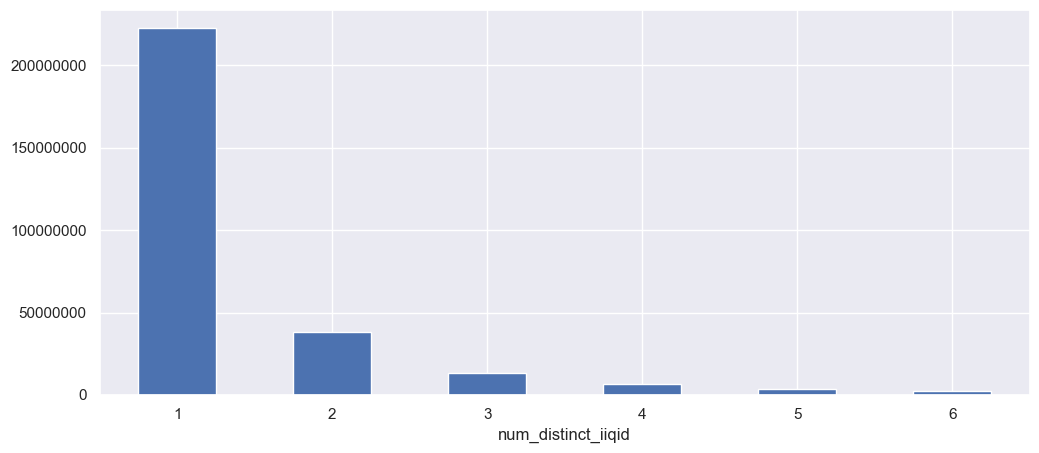

In [22]:
atena_popular_browsers.groupby('num_distinct_iiqid')['num_groups'].sum().nlargest(6).plot(kind='bar')
plt.xticks(rotation=0)
plt.ticklabel_format(style='plain', axis='y')

In [23]:
browsers_to_keep = browsers_sum[browsers_sum >= threshold].sort_values(ascending=False).index.tolist()
# browsers_to_keep

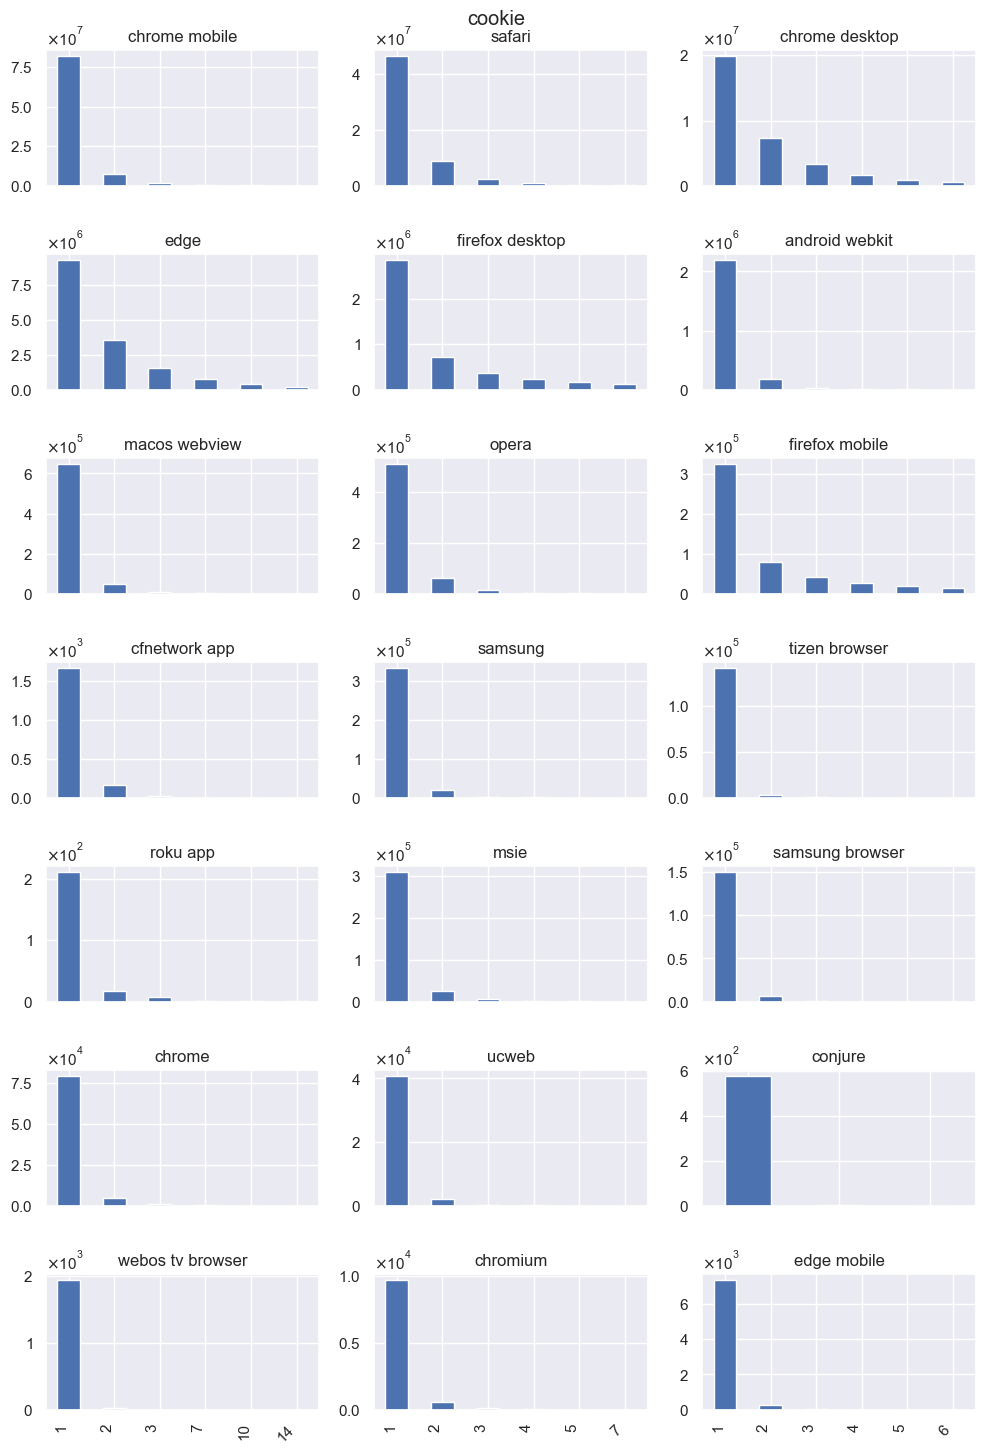

In [24]:
ncols = 3
nrows = len(browsers_to_keep) // 3
fig, axs = plt.subplots(ncols=ncols, nrows=nrows)
plt.subplots_adjust(hspace=0.5)
fig.set_figheight(20)
fig.set_figwidth(12)
fig.autofmt_xdate(rotation=45)

maid_type = 7
maids = {4: "maid", 7: "cookie"}
fig.suptitle(maids[maid_type], y=0.9)

for b, ax in zip(browsers_to_keep, axs.flatten()):
    atena_popular_browsers[(atena_popular_browsers['browser']==b) 
                           & (atena_popular_browsers['maid']==maid_type)].groupby(
        'num_distinct_iiqid')['num_groups'].sum().nlargest(6).plot(kind='bar', ax=ax)
    ax.set_title(b)
    ax.set_xlabel("")
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)

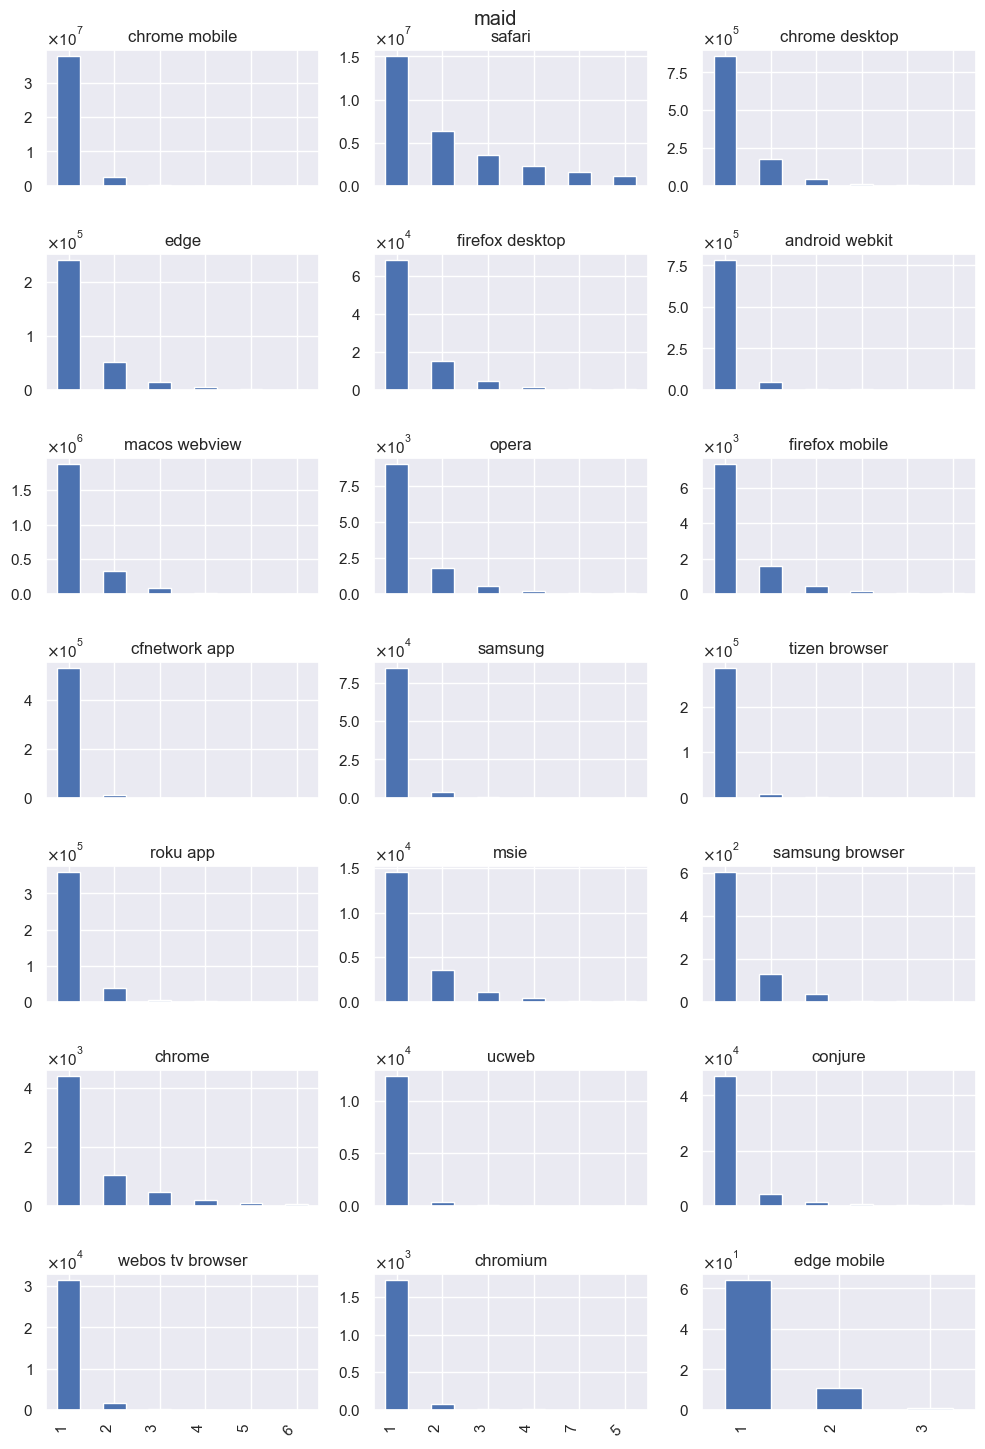

In [25]:
ncols = 3
nrows = len(browsers_to_keep) // 3
fig, axs = plt.subplots(ncols=ncols, nrows=nrows)
plt.subplots_adjust(hspace=0.5)
fig.set_figheight(20)
fig.set_figwidth(12)
fig.autofmt_xdate(rotation=45)

maid_type = 4
maids = {4: "maid", 7: "cookie"}
fig.suptitle(maids[maid_type], y=0.9)

for b, ax in zip(browsers_to_keep, axs.flatten()):
    atena_popular_browsers[(atena_popular_browsers['browser']==b) 
                           & (atena_popular_browsers['maid']==maid_type)].groupby(
        'num_distinct_iiqid')['num_groups'].sum().nlargest(6).plot(kind='bar', ax=ax)
    ax.set_title(b)
    ax.set_xlabel("")
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)

In [26]:
pivot_bm = atena_popular_browsers.pivot_table(index=['browser', 'maid'], columns='num_distinct_iiqid', values='num_groups', 
                                   aggfunc='sum').fillna(0).sort_values(by=1, ascending=False)

In [31]:
pivot_bm = pivot_bm.astype(int)

In [32]:
pivot_bm_agg = pivot_bm[[i for i in pivot_bm.columns if i >=6]].sum(axis=1)

In [37]:
pivot_bm.drop([i for i in pivot_bm.columns if i >=6], axis=1, inplace=True)
pivot_bm['6+'] = pivot_bm_agg

In [42]:
pivot_bm.columns = [str(c) for c in pivot_bm.columns]

In [67]:
browsers_and_maids = pivot_bm.loc[[r for r in pivot_bm.index if r[0] in browsers_to_keep]].sort_index()

In [128]:
browsers_and_maids = browsers_and_maids.loc[browsers_to_keep]

## Data with no HH

In [377]:
hhm = pd.read_csv("../Data/hhm.csv")

In [378]:
nhbm = pd.read_csv("../Data/nhbm2.csv")

In [379]:
hhm.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
num_distinct_iiqid,1660.0,23.25,19.87,1.0,6.0,18.0,37.00,85.0
maid,1660.0,5.99,1.42,4.0,4.0,7.0,7.00,7.0
num_groups,1660.0,194161.58,2828168.22,1.0,3.0,21.0,458.25,88793201.0


In [380]:
nhbm.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
num_distinct_iiqid,1124.0,21.70,19.29,1.0,5.0,15.0,35.00,75.0
maid,1124.0,6.15,1.35,4.0,4.0,7.0,7.00,7.0
num_groups,1124.0,46311.07,647168.99,1.0,2.0,13.0,210.75,18655055.0


In [381]:
def pivoting(data):
    data_bm = data.pivot_table(index=['browser', 'maid'], 
                                                columns='num_distinct_iiqid', 
                                                values='num_groups', 
                                       aggfunc='sum').fillna(0).sort_values(by=1, 
                                                                            ascending=False)
    data_bm = data_bm.astype(int)
    data_bm_agg = data_bm[[i for i in data_bm.columns if i >=6]].sum(axis=1)
    data_bm.drop([i for i in data_bm.columns if i >=6], axis=1, inplace=True)
    data_bm['6+'] = data_bm_agg
    data_bm.columns = [str(c) for c in data_bm.columns]
    return data_bm

In [382]:
pivoting(atena_popular_browsers).equals(pivot_bm)

True

In [383]:
hhm_bm = pivoting(hhm)
nhbm_bm = pivoting(nhbm)

In [384]:
top_browsers = hhm_bm[hhm_bm.index.get_level_values('maid')==7]\
    .nlargest(10, columns='1').index.get_level_values('browser')

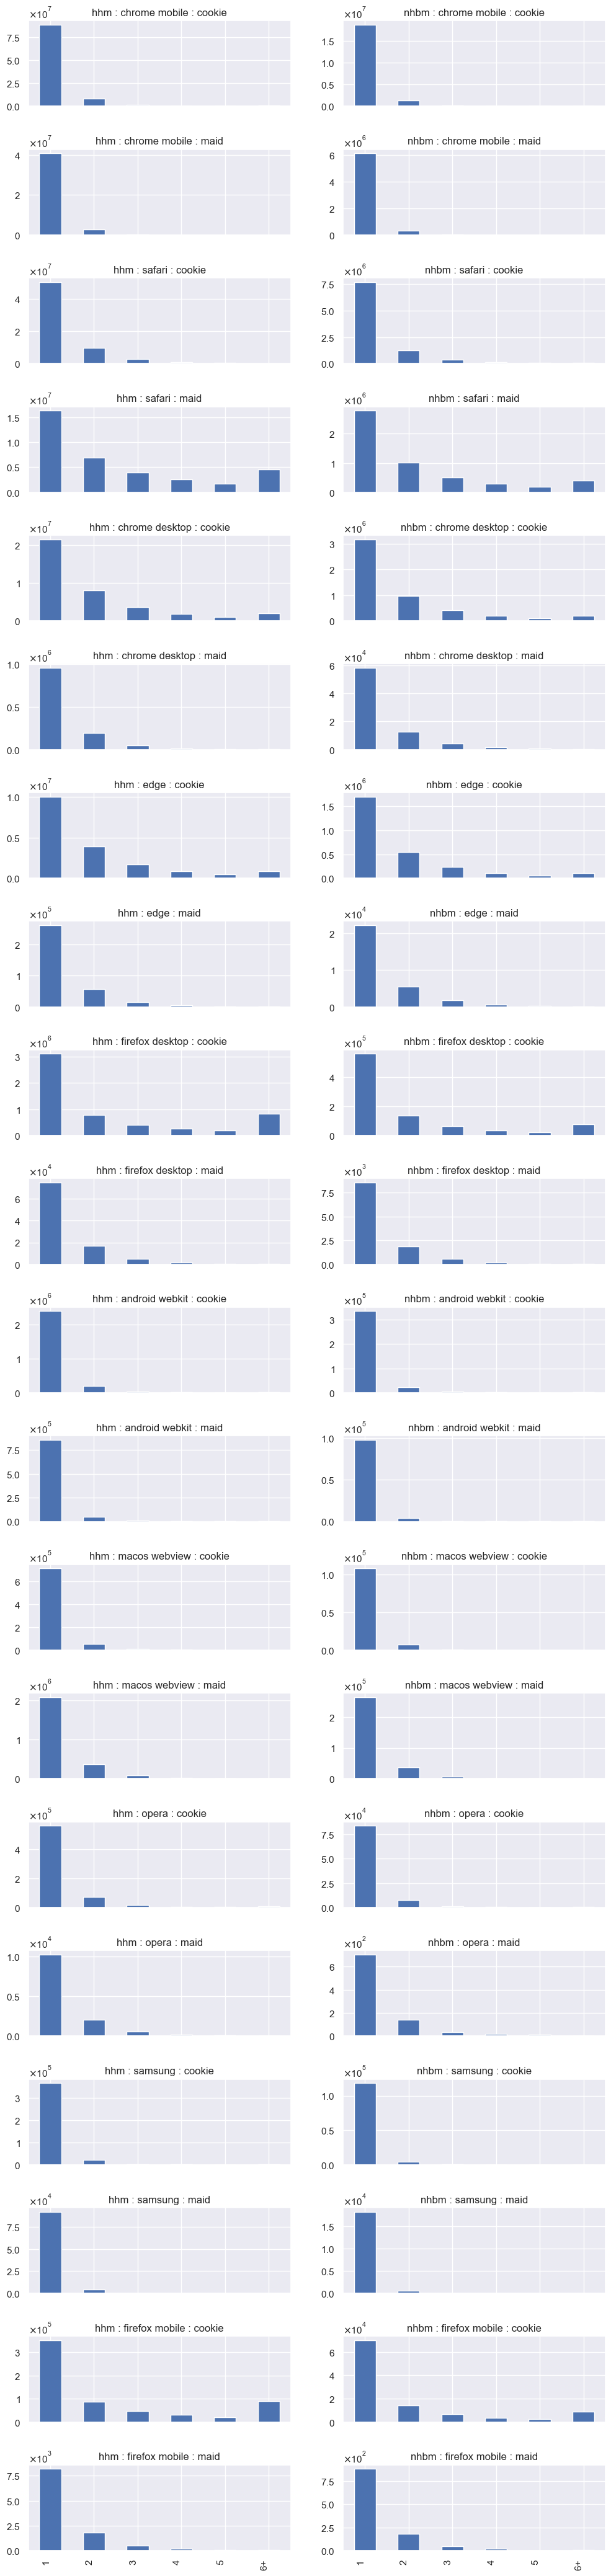

In [385]:
ncols = 2
nrows = 2*len(top_browsers)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows)
plt.subplots_adjust(hspace=0.5)
fig.set_figheight(60)
fig.set_figwidth(12)
fig.autofmt_xdate(rotation=45)

for i, b in enumerate(top_browsers):
    hhm_bm.loc[(b, 7)].plot(kind='bar', ax=axs[2*i][0])
    axs[2*i][0].set_title(f"hhm : {b} : cookie")
    nhbm_bm.loc[(b, 7)].plot(kind='bar', ax=axs[2*i][1])
    axs[2*i][1].set_title(f"nhbm : {b} : cookie")
    hhm_bm.loc[(b, 4)].plot(kind='bar', ax=axs[2*i+1][0])
    axs[2*i+1][0].set_title(f"hhm : {b} : maid")
    nhbm_bm.loc[(b, 4)].plot(kind='bar', ax=axs[2*i+1][1])
    axs[2*i+1][1].set_title(f"nhbm : {b} : maid")
    
for ax in axs:
    ax[0].set_xlabel("")
    ax[1].set_xlabel("")
    ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)

<Axes: >

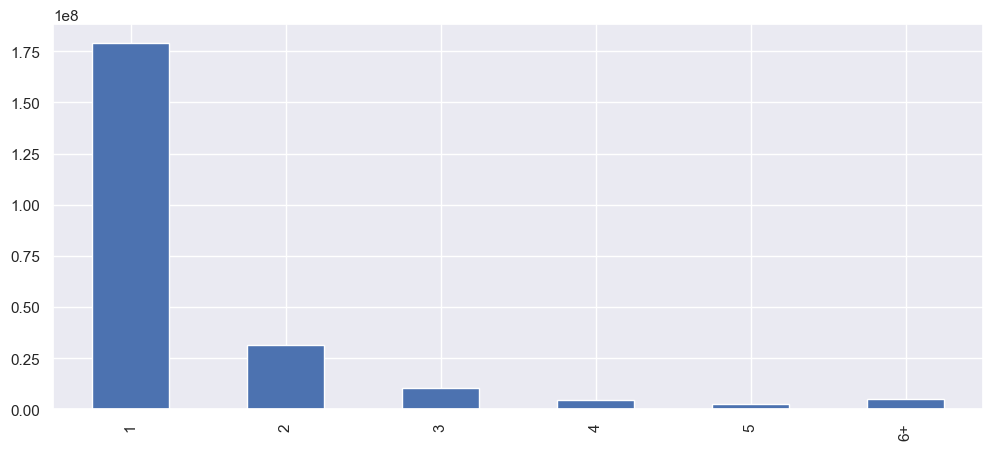

In [386]:
hhm_bm.xs(7, level=1, axis=0).sum(axis=0).plot(kind='bar')

<Axes: >

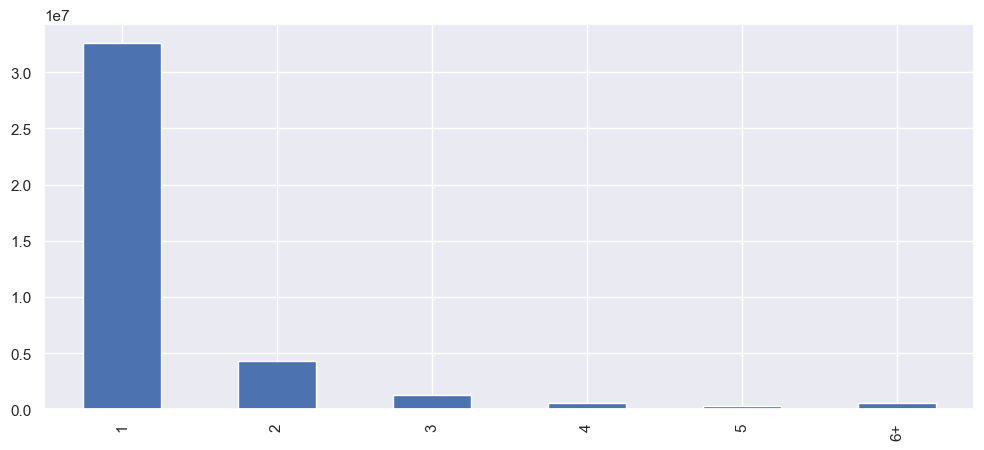

In [387]:
nhbm_bm.xs(7, level=1, axis=0).sum(axis=0).plot(kind='bar')

In [388]:
totals = pd.concat(
    [hhm[(hhm['maid']==7) & (hhm['browser']=='firefox desktop')]\
           .set_index('num_distinct_iiqid').sort_index()\
           .drop(['maid','browser'], axis=1),
    nhbm[(nhbm['maid']==7) & (nhbm['browser']=='firefox desktop')]\
     .set_index('num_distinct_iiqid').sort_index()\
     .drop(['maid','browser'], axis=1)],
    axis=1
).fillna(0)

In [389]:
totals.columns = ['hhm', 'nhbm']

In [390]:
totals_agg = totals.loc[[i for i in totals.index if i >= 6]].sum()
totals_agg

hhm     833564.0
nhbm     75839.0
dtype: float64

In [391]:
totals = totals.transpose().drop([i for i in totals.index if i >= 6], axis=1)
totals['+6'] = totals_agg

In [392]:
totals

num_distinct_iiqid,1,2,3,4,5,+6
hhm,3106442.0,784557.0,396606.0,256047.0,182236.0,833564.0
nhbm,561360.0,138667.0,63038.0,36326.0,22981.0,75839.0


<Axes: xlabel='num_distinct_iiqid'>

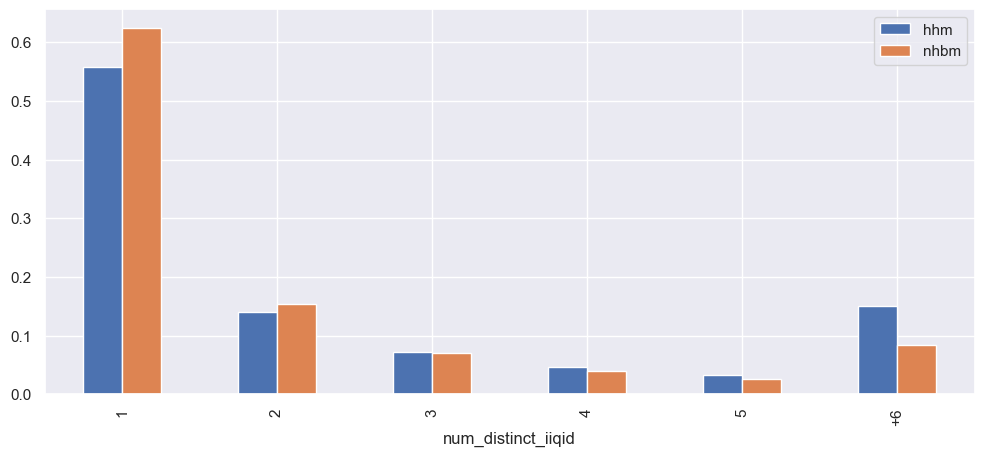

In [400]:
(totals.transpose() / totals.sum(axis=1)).plot(kind='bar', y=['hhm', 'nhbm'])